In [1]:
import random
from itertools import product
from math import sqrt
from typing import List

import matplotlib.pyplot as plt
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split


import scipy.sparse as sp
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import plotly.graph_objects as go
import seaborn as sns
from funcsigs import signature
from matplotlib.lines import Line2D
from sklearn.metrics import (auc, average_precision_score,
                             precision_recall_curve, roc_curve)


In [3]:
import pandas as pd
import numpy as np

In [4]:
import warnings

warnings.filterwarnings('ignore')

In [5]:
def novelty(predicted: List[list], pop: dict, u: int, n: int) -> (float, list):
    """
    Новизна рекомендаций 
    ----------    
    Базируется на статье:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

def prediction_coverage(predicted: List[list], catalog: list, unseen_warning: bool=False) -> float:
    """
    Покрытие рекомендаций (по пользователю)
    
    ----------    
    Базируется на статье:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    
    unique_items_catalog = set(catalog)
    if len(catalog)!=len(unique_items_catalog):
        raise AssertionError("Дубликаты в каталоге")

    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_items_pred = set(predicted_flattened)
    
    if not unique_items_pred.issubset(unique_items_catalog):
        if unseen_warning:
            warnings.warn("В рекомендациях есть элементы не из каталога. "
                "Игнорируем")
            unique_items_pred = unique_items_pred.intersection(unique_items_catalog)
        else:
            raise AssertionError("В рекомендациях есть элементы не из каталога.")
    
    num_unique_predictions = len(unique_items_pred)
    prediction_coverage = round(num_unique_predictions/(len(catalog)* 1.0)* 100, 2)
    return prediction_coverage

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage

def _ark(actual: list, predicted: list, k=10) -> float:
    """
    average recall @ k.
   
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)


def _apk(actual: list, predicted: list, k=10) -> float:
    """
    average precision @ k.
    
    """
    if not predicted or not actual:
        return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives

def mark(actual: List[list], predicted: List[list], k=10) -> float:
    """
    mean average recall @ k.
 
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])

def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    mean average precision @ k.
    
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

def personalization(predicted: List[list]) -> float:
    """
    Расчет персонализации для пользователя
    Чем больше, тем лучше, т.к. набор элементов очень разный и на оборот.
    
    """

    def make_rec_matrix(predicted: List[list]) -> sp.csr_matrix:
        df = pd.DataFrame(data=predicted).reset_index().melt(
            id_vars='index', value_name='item',
        )
        df = df[['index', 'item']].pivot(index='index', columns='item', values='item')
        df = pd.notna(df)*1
        rec_matrix = sp.csr_matrix(df.values)
        return rec_matrix

    predicted = np.array(predicted)
    rec_matrix_sparse = make_rec_matrix(predicted)

    similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)


    dim = similarity.shape[0]
    personalization = (similarity.sum() - dim) / (dim * (dim - 1))
    return 1-personalization

def _single_list_similarity(predicted: list, feature_df: pd.DataFrame, u: int) -> float:
    """
    Вычисление вложенного списка схожести

    """
    if not(predicted):
        raise Exception('Predicted list is empty, index: {0}'.format(u))


    recs_content = feature_df.loc[predicted]
    recs_content = recs_content.dropna()
    recs_content = sp.csr_matrix(recs_content.values)

    similarity = cosine_similarity(X=recs_content, dense_output=False)


    upper_right = np.triu_indices(similarity.shape[0], k=1)

    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

def intra_list_similarity(predicted: List[list], feature_df: pd.DataFrame) -> float:
    """
    Среднее значение по вложенному списку схожести
    
    """
    feature_df = feature_df.fillna(0)
    Users = range(len(predicted))
    ils = [_single_list_similarity(predicted[u], feature_df, u) for u in Users]
    return np.mean(ils)

def mse(y: list, yhat: np.array) -> float:

    mse = mean_squared_error(y, yhat)
    return mse

def rmse(y: list, yhat: np.array) -> float:
    
    rmse = sqrt(mean_squared_error(y, yhat))
    return rmse

def make_confusion_matrix(y: list, yhat: list) -> None:

    cm = confusion_matrix(y, yhat, labels=[1,0])
    cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)*100

    fmt = ".2f"
    _ = cm.max() / 2. # TODO: Unused argument
    descriptions = np.array([["True Positive", "False Negative"], ["False Positive", "True Negatives"]])
    colors = np.array([["green", "red"], ["red", "green"]])
    plt.imshow([[0,0],[0,0]], interpolation='nearest', cmap=plt.cm.Greys)
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt)+'%\n' + descriptions[i, j],
                     horizontalalignment="center",
                     color=colors[i,j])
    plt.axhline(y=0.5, xmin=0, xmax=1, color="black", linewidth=0.75)
    plt.axvline(x=0.5, ymin=0, ymax=1, color="black", linewidth=0.75)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], [1,0], rotation=45)
    plt.yticks([0,1], [1,0])
    plt.show()

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def recommender_precision(predicted: List[list], actual: List[list]) -> int:

    precision = np.mean(list(map(lambda x, y: np.round(_precision(x,y), 4), predicted, actual)))
    return precision


def recommender_recall(predicted: List[list], actual: List[list]) -> int:

    def calc_recall(predicted, actual):
        reca = [value for value in predicted if value in actual]
        reca = np.round(float(len(reca)) / float(len(actual)), 4)
        return reca

    recall = np.mean(list(map(calc_recall, predicted, actual)))
    return recall

In [6]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = df[item_id_column].value_counts().reset_index()
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]
        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()


def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

def personalization_plot(personalization_scores: list, model_names: list) -> None:
    """
    Plots the personalization for a set of models to compare.
    ----------
    personalization_scores: list
        list of personalization scores in same order as model_names
        example: [0.13, 0.52, 0.36]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A personalization plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=personalization_scores)

    #set labels
    ax.set_title("Personalization in %")
    ax.set_ylabel("personalization")

    plt.show()

def intra_list_similarity_plot(intra_list_similarity_scores, model_names):
    """
    Plots the intra-list similarity for a set of models to compare.
    ----------
    intra_list_similarity_scores: list
        list of intra-list similarity scores in same order as model_names
        example: [0.13, 0.52, 0.36]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A intra-list similarity plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=intra_list_similarity_scores)

    #set labels
    ax.set_title("Similarity in %")
    ax.set_ylabel("similarity in %")

    plt.show()

def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This list is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()



def class_separation_plot(pred_df, n_bins=150, threshold=None, figsize=(10,6), title=None):
    """
    Plots the predicted class probabilities for multiple classes.
    Usefull for visualizing predicted interaction values such as 5 star ratings, where a "class" is a star rating,
    or visualizing predicted class probabilities for binary classification model or recommender system.
    The true class states are colored.
    ----------
    pred_df: pandas dataframe
        a dataframe containing a column of predicted interaction values or classification probabilites,
        and a column of true class 1 and class 0 states.
        This dataframe must contain columns named "predicted" and "truth"
        example:
        	predicted | truth
        	5.345345	|  5
        	2.072020	|  2
    n_bins: number of bins for histogram.
    threshold: float. default = 0.5
        A single number between 0 and 1 identifying the threshold to classify observations to class
        example: 0.5
    figsize: size of figure
    title: plot title
    Returns:
    -------
        A classification probability plot
    """
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF", "#FC5FA3"]
    classes = pred_df.truth.unique()
    plt.figure(figsize=figsize)
    for i in range(len(classes)):
        single_class = classes[i]
        sns.distplot( pred_df.query("truth == @single_class")["predicted"] , bins=n_bins,  label="True {}".format(single_class)) #color=recommender_palette[i],
    plt.legend()
    if threshold == None: pass
    else: plt.axvline(threshold, color="black", linestyle='--')
    plt.xlabel("Predicted value")
    plt.ylabel("Frequency")
    if title == None: plt.title(" ")
    else: plt.title(title)
    plt.show()


def roc_plot(actual, model_probs, model_names, figsize=(10,10)):
    """
    Receiver Operating Characteristic Plot. Can plot multiple models.
    ----------
    actual: array of dataframe of true classes assignements.
        example:
        [1,1,0,1,0]
    model_probs: list of arrays
        a list containing classification probabilites for each model in order.
        example:
        model_probs = [class_probs_1, class_probs_2]
    model_names: list of strings
        a list containing names for each model in order.
        example:
        model_names = ["GBT", "Logistic Regression"]
    figsize: size of figure
    Returns:
    -------
        Receiver Operating Characteristic Plot with AUC in the legend.
    """
    model_names = make_listy(model_names)
    if not is_listy(model_probs): model_probs = [model_probs]

    if len(model_names) > 5:
        return ValueError("Can only compare 5 models or less.")

    colors = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]

    for m in range(len(model_names)):
        fpr, tpr, _ = roc_curve(actual, model_probs[m])
        roc_auc = auc(fpr, tpr)
        ax = sns.lineplot(x=fpr,
                          y=tpr,
                          lw=2,
                          color=colors[m],
                          label = model_names[m] + ' AUC = %0.4f' % roc_auc)
    
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_title('Receiver Operating Characteristic Plot')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    
    plt.show()


def precision_recall_plot(targs, preds, figsize=(6,6)):
    """
    Plots the precision recall curve
    ----------
    targs: array-like true class labels
    preds: array-like predicted probabilities
    figsize: size of figure
    Returns:
    -------
        A precision and recall curve
    """
    average_precision = average_precision_score(targs, preds)
    precision, recall, _ = precision_recall_curve(targs, preds)
    plt.figure(figsize=figsize)
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
        average_precision))
    plt.show()


def make_listy(p):
    if isinstance(p, str): return [p]
    try:
        _ = iter(p)
    except TypeError:
        p = [p]
    return p


def is_listy(x): return isinstance(x, (tuple,list))

def metrics_plot(model_names, coverage_scores, personalization_scores, intra_list_similarity_scores):

    """
    Plots the coverage, personalization and intra-list similarity for a set of models to compare.
    ----------
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    coverage_scores: list
        list of scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    personalization_scores: list
        list of scores in same order as model_names
        example: [0.43, 0.23, 0.44]
    intra_list_similarity: list
        list of scores in same order as model_names
        example: [0.23, 0.21, 0.69]
    Returns:
    -------
        An interactive metrics plot
    """

    fig = go.Figure()

    for model_name, coverage, personalization, intra_list_similarity in zip(model_names, coverage_scores, personalization_scores, intra_list_similarity_scores):
        fig.add_trace(go.Scatterpolar(
              r=[coverage, personalization * 100, intra_list_similarity * 100],
              theta=['coverage','personalization','intra list similarity'],
              fill='tonext',
              name=model_name
        ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 100]
        )),
      showlegend=True
    )

    fig.show()

### Загрузка данных

In [9]:
ratings = pd.read_csv('ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [11]:
# только больше 10 рейтингов
n=100
users = ratings["userId"].value_counts()
users = users[users>n].index.tolist()

ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(62692, 4)


,userId,movieId,rating,timestamp
125,4,10,4.0,949810645
126,4,34,5.0,949919556
127,4,112,5.0,949810582


### Фичи по проекту

In [13]:
rated_movies = ratings["movieId"].tolist()

# получить фичи по по фильмам
movies = pd.read_csv('movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

# разбивка жанров 
movies = movies["genres"].str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9 ])
movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

# создаем единую таблицу
movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


### Обзор распределения рейтингов

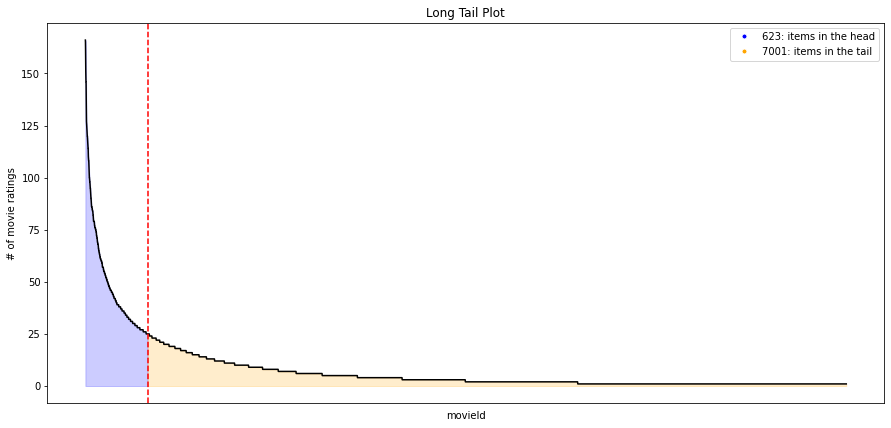

In [14]:
fig = plt.figure(figsize=(15, 7))
long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

In [ ]:
### CF рекомендатор

In [15]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [16]:
algo = SVD()
algo.fit(trainset)

In [17]:
# предикт
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,199,104879,3.5,3.775284
1,595,2355,5.0,4.027709
2,665,5991,4.0,3.604983
3,213,1240,3.5,3.780766
4,36,21,3.0,3.798470


In [18]:
# MSE и RMSE
print("MSE: ", mse(test.actual, test.cf_predictions))
print("RMSE: ", rmse(test.actual, test.cf_predictions))

MSE:  0.35436793732739225
RMSE:  0.5952881128725755


In [19]:
# матрица предиктов
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [21]:
cf_model

movieId,1,2,3,4,5,6,7,8,9,10,...,148238,148626,149352,149354,152081,153584,155611,159462,160438,161594
userId,,,,,,,,,,,,,,,,,,,,,
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.041647,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,3.770413,3.63395,3.701165,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
659,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
664,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [22]:
# пример
get_users_predictions(547, 10, cf_model)

[1221, 969, 953, 912, 1230, 50, 908, 2858, 2303, 1089]

In [ ]:
# юзер-факт (т.е. те элементы, которые пользователь оценил)

In [23]:
test = test.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})
test = test.set_index("userId")

In [24]:
# сделать рекомендации для всех по тестовому набору

cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions
userId,,
4,"[260, 1032, 1033, 10, 1544, 913, 1022, 153, 41...","[858, 913, 260, 1225, 1079, 1089, 2289, 1213, ..."
8,"[4993, 4226, 4995, 40583, 1674, 33166, 2841, 3...","[858, 50, 4993, 1196, 4226, 318, 1198, 1258, 2..."
15,"[5120, 33794, 3077, 1546, 3083, 2572, 1036, 25...","[858, 953, 1230, 1148, 1233, 1210, 750, 2918, ..."
17,"[27266, 1411, 2692, 1923, 1674, 2571, 908, 590...","[50, 2571, 608, 541, 908, 924, 912, 1411, 1258..."
19,"[1036, 527, 21, 535, 541, 35, 1077, 58, 1082, ...","[1221, 260, 903, 1233, 1214, 527, 194, 1304, 2..."


### Создаем расчет на основе популярных рекомендаций

In [25]:
# рекомендации по всем
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
4,"[260, 1032, 1033, 10, 1544, 913, 1022, 153, 41...","[858, 913, 260, 1225, 1079, 1089, 2289, 1213, ...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11..."
8,"[4993, 4226, 4995, 40583, 1674, 33166, 2841, 3...","[858, 50, 4993, 1196, 4226, 318, 1198, 1258, 2...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11..."
15,"[5120, 33794, 3077, 1546, 3083, 2572, 1036, 25...","[858, 953, 1230, 1148, 1233, 1210, 750, 2918, ...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11..."
17,"[27266, 1411, 2692, 1923, 1674, 2571, 908, 590...","[50, 2571, 608, 541, 908, 924, 912, 1411, 1258...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11..."
19,"[1036, 527, 21, 535, 541, 35, 1077, 58, 1082, ...","[1221, 260, 903, 1233, 1214, 527, 194, 1304, 2...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11..."


### Создаем расчет на основе рандомных рекомендаций

In [26]:
# рекомендации по всем

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
4,"[260, 1032, 1033, 10, 1544, 913, 1022, 153, 41...","[858, 913, 260, 1225, 1079, 1089, 2289, 1213, ...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11...","[2826, 555, 4963, 93443, 2640, 8874, 33794, 30..."
8,"[4993, 4226, 4995, 40583, 1674, 33166, 2841, 3...","[858, 50, 4993, 1196, 4226, 318, 1198, 1258, 2...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11...","[942, 29, 858, 858, 27611, 1272, 1136, 1249, 5..."
15,"[5120, 33794, 3077, 1546, 3083, 2572, 1036, 25...","[858, 953, 1230, 1148, 1233, 1210, 750, 2918, ...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11...","[2746, 2085, 122886, 7375, 1197, 30793, 489, 6..."
17,"[27266, 1411, 2692, 1923, 1674, 2571, 908, 590...","[50, 2571, 608, 541, 908, 924, 912, 1411, 1258...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11...","[165, 30810, 5540, 1282, 1136, 3019, 31410, 42..."
19,"[1036, 527, 21, 535, 541, 35, 1077, 58, 1082, ...","[1221, 260, 903, 1233, 1214, 527, 194, 1304, 2...","[356, 296, 260, 1270, 593, 1196, 2571, 318, 11...","[3507, 2115, 608, 3527, 3006, 1213, 1079, 2761..."


### расчет Recall

In [27]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [28]:
pop_mark = []
for K in np.arange(1, 20):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.0035834096734322406,
 0.0059092854875060375,
 0.007828295398578943,
 0.009072393308641635,
 0.01026918820039271,
 0.011156203130454848,
 0.012009328274708264,
 0.012979500240619576,
 0.013771130946271845,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999,
 0.014391909798674999]

In [29]:
random_mark = []
for K in np.arange(1, 20):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.0004146097848608205,
 0.0006735916412783029,
 0.0009320956177608213,
 0.0010980426964862667,
 0.0012660395459470827,
 0.001392970172630639,
 0.001549984559448256,
 0.0016852137492105457,
 0.0017744057380573329,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124,
 0.0018723356875217124]

In [30]:
cf_mark = []
for K in np.arange(1, 20):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.021573720666597983,
 0.043147441333195966,
 0.06472116199979394,
 0.08629488266639193,
 0.10786860333298989,
 0.12944232399958788,
 0.1510160446661859,
 0.17258976533278386,
 0.19416348599938185,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979,
 0.21573720666597979]

### Визуализация MAR@K

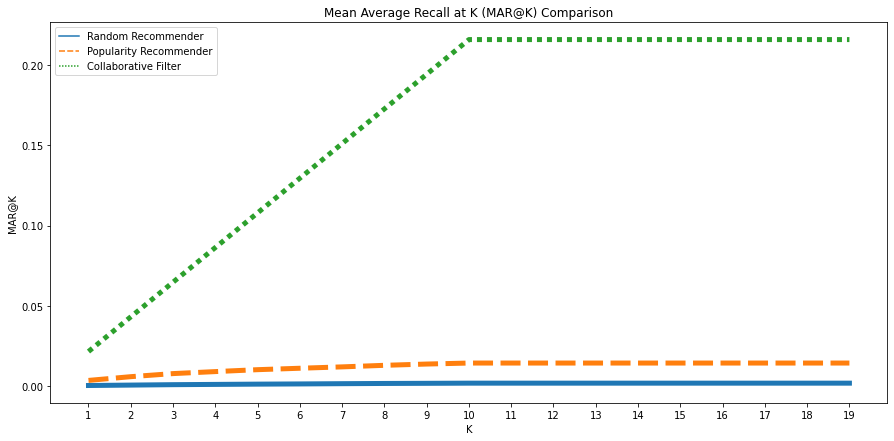

In [31]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,19+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

### Coverage Plot

In [32]:
catalog = ratings.movieId.unique().tolist()
random_coverage = prediction_coverage(ran_recs, catalog)
pop_coverage = prediction_coverage(pop_recs, catalog)
cf_coverage = prediction_coverage(cf_recs, catalog)

In [33]:
random_coverage, pop_coverage, cf_coverage

(19.66, 0.13, 7.59)

In [34]:
# N=100 для определенного 
random_cat_coverage = catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = catalog_coverage(cf_recs, catalog, 100)

In [35]:
random_cat_coverage, pop_cat_coverage, cf_cat_coverage

(8.8, 0.13, 4.42)

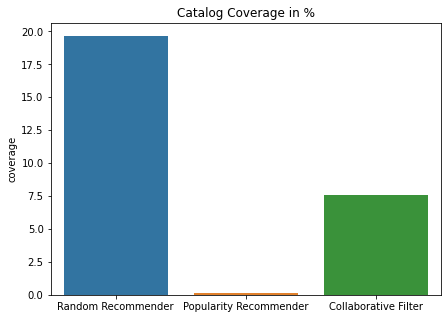

In [36]:
# визуализация
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
coverage_plot(coverage_scores, model_names)

### Novelty

In [37]:
nov = ratings.movieId.value_counts()
pop = dict(nov)

In [38]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)

In [39]:
print(random_novelty, pop_novelty, cf_novelty)

3.5526922033852393 0.6122621797132589 1.9498610790211741


In [40]:
#### Personalization

In [41]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [42]:
personalization(predicted=example_predictions)

0.9166666666666666

In [43]:
#### Intra-list Similarity (вложенный список)

In [44]:
# пользователи
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 671],
    [7, 4, 6, 671]
]

In [45]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [46]:
intra_list_similarity(example_predictions, feature_df)

0.4444444444444444

### Classification Probability Plot

In [47]:
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.416946,1.0
1,0.646010,1.0
2,0.949423,1.0
3,0.769791,1.0
4,0.579441,1.0


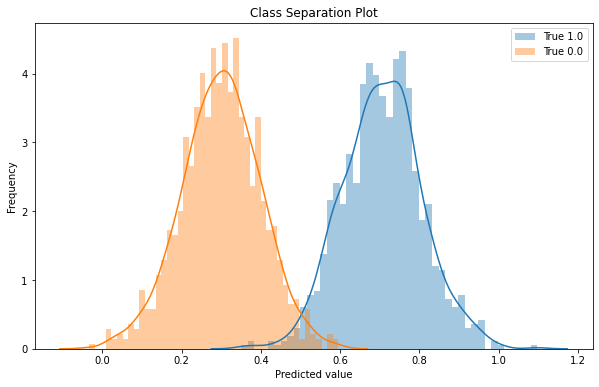

In [48]:
class_separation_plot(pred_df, n_bins=45, title="Class Separation Plot")

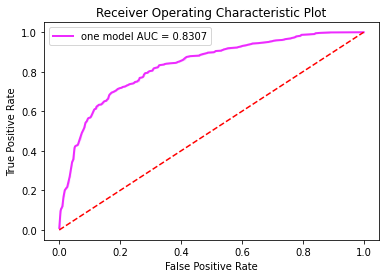

In [49]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

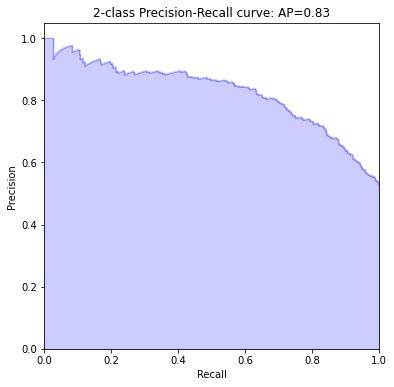

In [50]:
precision_recall_plot(targs=actual, preds=model_probs)

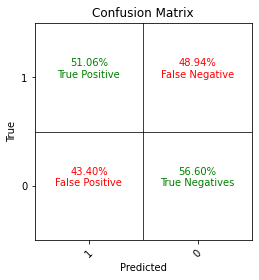

In [51]:
y_confusion_matrix = [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
                      0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
                      1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
                      1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
                      1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]

yhat_confusion_matrix = [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
                         0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
                         1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
                         1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
                         1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]


make_confusion_matrix(y=y_confusion_matrix, yhat=yhat_confusion_matrix)

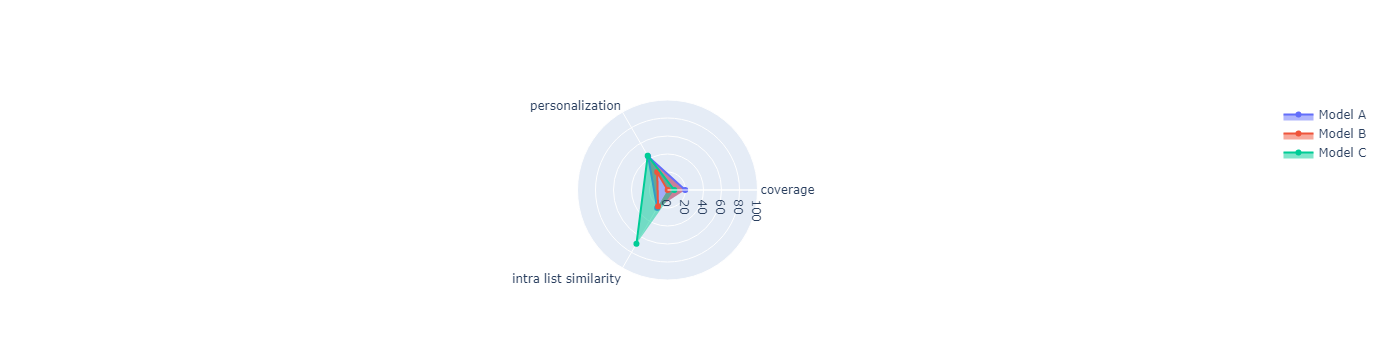

In [53]:
metrics_plot(model_names=['Model A', 'Model B', 'Model C'],
             coverage_scores=[19.66, 0.13, 7.59],
             personalization_scores=[0.43, 0.23, 0.44],
             intra_list_similarity_scores = [0.23, 0.21, 0.69])